<!-- # Notebook for Simulating $\hat c_j^i$ Distribution -->

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from numpy import linalg as LA

## Configuration

### $X^i$ ~ $N(0, I_d)$
### $w^i$ ~ $U[-10, 10]$

Creating the toy dataset with n = 200, $m_i$ = 10, and d = 10.

In [2]:
NUM_SAMPLES = 10
NUM_CLIENTS = 50
NUM_CLUSTERS = 2

## Creating Dataset

In [52]:
def get_data(num_features, num_clusters=NUM_CLUSTERS, num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0):
    w = np.random.uniform(-5,5,(num_clusters,num_features)) # here we shape all w for all clients
    clusters = []

    X = np.zeros ((num_clusters,num_clients,num_training_samples,num_features)) 
    y = np.zeros ((num_clusters,num_clients,num_training_samples))
    localdatasets = np.zeros((num_clusters,num_clients,num_training_samples,(num_features+1)))
    clusterassgts = np.zeros((num_clusters,num_clients,num_training_samples))
    for iter_cluster in range(num_clusters): 
        for iter_node in range(0, num_clients):
            X[iter_cluster, iter_node,:,:] = np.random.randn(num_training_samples, num_features)
            r = X[iter_cluster, iter_node,:,:] @ w[iter_cluster, :].reshape(-1, 1) + np.random.normal(loc=0.0, scale=noise, size=(NUM_SAMPLES, 1))
            y[iter_cluster, iter_node,:] = r.squeeze()
            clusters.append(iter_cluster)
            for iter_sample in range(0,num_training_samples): 
                localdatasets[iter_cluster,iter_node,iter_sample,:] = np.hstack((X[iter_cluster, iter_node,iter_sample,:],y[iter_cluster, iter_node,iter_sample].reshape(-1,))).reshape(1,-1)
                clusterassgts[iter_cluster,iter_node,iter_sample] = iter_cluster


    X = X.reshape(-1, X.shape[2], X.shape[3])
    y = y.reshape(-1, y.shape[2])
    return X, y, w, clusters

## Algorithm

In [53]:
def w_mean_squared_error(theta, true_w):
    m = len(theta)
    mse = (1 / m) * np.sum((theta - true_w) ** 2)
#     mse = np.sum((theta - true_w) ** 2)
    return mse


def mean_squared_error(theta, X, y):
    m = len(y)
    predictions = X.dot(theta)
    mse = (1 / m) * np.sum((predictions - y) ** 2)
    return mse

def bulk_mean_squared_error(theta, X, y):
    m = len(y)
    predictions = X.dot(theta.T).T
    mse = (1 /  m) * np.sum((predictions - y)**2, axis=1)
    return mse

def gradient(theta, X, y):
    m = len(y)
    gradient = (2 / m) * X.T.dot(X.dot(theta) - y)
    return gradient

def bulk_gradient(theta, X, y):
    array1 = X
    array2 = X.dot(theta) - y
    result = np.einsum('ijk,ij->ik', array1, array2)
    return result
    

In [54]:
def algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = np.random.random((X.shape[0], X.shape[-1]))
    loss_history = []
    
    for k in range(K):
        loss = []
        for i in range(N):
            selected_nodes = random.sample(nodes, SUBSET_SIZE+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:SUBSET_SIZE] 
            
            w_tilde = w_hat[i] - alpha * bulk_gradient(w_hat[i], X[selected_nodes], y[selected_nodes])
            rewards = mean_squared_error(w_hat[i], X[i], y[i]) - bulk_mean_squared_error(w_tilde, X[i], y[i])
            best_w = w_tilde[np.argmax(rewards)]

            w_hat[i] = best_w   
#             loss.append(mean_squared_error(w_hat[i], X[i], y[i]))
            loss.append(w_mean_squared_error(w_hat[i], w[clusters[i]]))
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

IFCA

In [78]:
import argparse
import json
import os
import time
import itertools
import pickle

import torch
import numpy as np

LR_DECAY = False


def ifca_main(X, y, w, clusters, alpha, num_epochs=300):
    config = {
        "m" : len(X),            # number of machines
        "p" : len(w),              # number of cluster groups (expects m % p == 0)
        "n" : len(X[0]),            # number of datapoints for each machine
        "d" : len(w[0]),           # dimension of the datapoint
        "r" : 0.5,            # separation parameter for synthetic data generation
#         "num_epochs": 300,    # number of data pass
        "num_epochs": num_epochs,    # number of data pass
        "score":"set",        # scoring method ( only 'set' is used)
        "lr":alpha,             # learning rate
        "data_seed":0,        # random seed for generating data
        "train_seed":0 
    }
    
    dataset_generate = DatasetGenerate(X, y, w, clusters, config)
    dataset_generate.setup()
    dataset = dataset_generate.generate_dataset()

    exp = TrainCluster(config)
    exp.setup(dataset= dataset)
    results, models = exp.run()
    return results, models, exp


def random_normal_tensor(size, loc = 0, scale = 1):
    return torch.randn(size) * scale + loc


class DatasetGenerate(object):
    def __init__(self, X, y, w, clusters, config, seed = 0):
        self.seed = 0
        self.config = config
        self.X = X
        self.y = y
        self.w = w
        self.clusters = clusters

        assert self.config['m'] % self.config['p'] == 0

    def setup(self):
        # print('seeding', self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

        # param settings
        # p even -> loc: [-3, -1, 1, 3] p = 4
        # p odd -> loc: [-6, -4, -2, 0, 2, 4, 6] p = 7
        p = int(self.config['p'])
        self.param_settings = [ -p + 1 + 2*i for i in range(p)]


    def generate_dataset(self):
        dataset = {}
        dataset['config'] = self.config

        # generate parameter set for each cluster
        params = self.w
        dataset['params'] = params
        dataset['data'] = []

        # generate dataset for each machine
        cluster_assignment = self.clusters
        dataset['cluster_assignment'] = cluster_assignment

        for m_i in range(len(X)):
            data_X = torch.tensor(self.X[m_i], dtype=torch.float32)
            data_y = torch.tensor(self.y[m_i], dtype=torch.float32)

            dataset['data'].append((data_X, data_y))

        self.dataset = dataset
        return dataset
        
        
class TrainCluster(object):
    def __init__(self, config):
        self.seed = config['train_seed']
        self.config = config

        assert self.config['m'] % self.config['p'] == 0

    def setup(self, dataset = None):
        # print('seeding', self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

        if dataset != None:
            self.dataset = dataset
        else:
            raise exception('dataset is none')

        p = self.config['p']
        d = self.config['d']
        m = self.config['m']
        n = self.config['n']

        self.models = [ SimpleLinear(input_size=d) for p_i in range(p)] # p models with p different params of dimension(1,d)
        self.criterion = torch.nn.MSELoss()

        self.epoch = None

        self.lr_decay_info = None


    def run(self):
        num_epochs = self.config['num_epochs']
        lr = self.config['lr']
        self.initialize_weights()
        # self.warm_start()
        results = []

        for epoch in range(num_epochs):
            self.epoch = epoch
            result, models = self.train(lr = lr)

            result['epoch'] = epoch
            results.append(result)

#             print(f" epoch {self.epoch} min_loss {result['min_loss']:3f} min_dist {result['min_dist']:3f} lr {lr:.5f}")
            # print(f"      min_losses {result['min_losses']}")
#             print(result["cluster_assignment_ct"], result["closest_cluster"])

            if LR_DECAY and self.determine_lr_decay(result):
                # lr = lr * 0.1
                lr = lr * 0.8

            if LR_DECAY and lr < 0.0001:
                print('break due to lr < 0.0001 in epoch', epoch)
                break

        return results, models


    def cleanup(self):
#         os.remove(self.dataset_fname)
        pass


    def determine_lr_decay(self,result):

        if self.lr_decay_info == None:
            self.lr_decay_info = {}
            dd = self.lr_decay_info
            dd['ct'] = 0
            dd['loss'] = -1

        dd = self.lr_decay_info
        if dd['loss']== -1:
            dd['loss'] = result['min_loss']
        else:
            if dd['loss'] - 1.0 > result['min_loss']:
                # still converging
                dd['ct'] = 0
                dd['loss'] = result['min_loss']
            else:
                # maybe converged
                dd['ct'] += 1

        if dd['ct'] > 5:
            dd['loss'] = result['min_loss']
            dd['ct'] = 0
            return True
        else:
            return False


    def train(self, lr):
        p = self.config['p']
        d = self.config['d']
        m = self.config['m']
        n = self.config['n']
        result = {}

        # calc loss and grad
        losses = {}
        grads = {}
        avg_losses = []
    
        for m_i in range(m):
            for p_i in range(p):
                (X, y) = self.dataset['data'][m_i]

                loss_val, grad = calculate_loss_grad(self.models[p_i], self.criterion, X, y)
                losses[(m_i,p_i)] = loss_val
                grads[(m_i,p_i)] = grad

        # calculate scores
        scores = {}
        for m_i in range(m):
            machine_losses = [ losses[(m_i,p_i)] for p_i in range(p) ]

            if self.config['score'] == 'set':
                min_p_i = np.argmin(machine_losses)
                for p_i in range(p):
                    if p_i == min_p_i:
                        scores[(m_i,p_i)] = 1
                    else:
                        scores[(m_i,p_i)] = 0

            elif self.config['score'] == 'em':

                from scipy.special import softmax
                softmaxed_loss = softmax(machine_losses)
                for p_i in range(p):
                    scores[(m_i,p_i)] = softmaxed_loss[p_i]

            else:
                assert self.config['score'] in ['set', 'em']

        # apply gradient update
        for p_i in range(p):
            cluster_scores = [ scores[(m_i,p_i)] for m_i in range(m) ]
            cluster_grads = [ grads[(m_i,p_i)] for m_i in range(m) ]

            self.models[p_i].zero_grad()
            weight = self.models[p_i].weight()
            tmp = gradient_update(cluster_scores, cluster_grads)
            weight.data -= lr * tmp
        
        for m_i in range(m):
            for p_i in range(p):
                model_weights = self.models[p_i].weight()[0].detach().numpy()
                avg_losses.append(w_mean_squared_error(model_weights, w[p_i]))
                
        avg_losses = np.mean(avg_losses)
        result['avg_loss'] = avg_losses

        # evaluate min_losses
        min_losses = []
        cluster_assignment = []
        for m_i in range(m):
            machine_losses = [ losses[(m_i,p_i)] for p_i in range(p) ]
            min_loss = np.min(machine_losses)
            min_losses.append(min_loss)

            machine_scores = [ scores[(m_i,p_i)] for p_i in range(p) ]
            assign = np.argmax(machine_scores)

            cluster_assignment.append(assign)



        result["min_loss"] = np.mean(min_losses)
        result["min_losses"] = min_losses
        result['cluster_assignment'] = cluster_assignment

        cluster_assignment_ct = [0 for p_i in range(p)]
        for m_i in range(m):
            cluster_assignment_ct[cluster_assignment[m_i]] += 1

        result["cluster_assignment_ct"] = cluster_assignment_ct

        closest_cluster = [-1 for _ in range(p)]
        min_dists = []
        for p_i in range(p):
            weight = self.models[p_i].weight()
            distances = []
            for p_j in range(p):
                param_ans = self.dataset['params'][p_j]
                distances.append(torch.norm(weight.data - param_ans, 2))
            closest_cluster[p_i] = np.argmin(distances)
            min_dist = np.min(distances)
            min_dists.append(min_dist)

        result["min_dist"] = np.mean(min_dists)
        result["min_dists"] = min_dists

        result["closest_cluster"] = closest_cluster
        

        return result, self.models

    def initialize_weights(self):
#         p = self.config['p']
#         random_number = np.random.normal() # dummy

#         for p_i in range(p):
#             weight = self.models[p_i].weight()
#             d = weight.shape[1]
#             param = torch.tensor(np.random.binomial(1, 0.5, size=(1,d)).astype(np.float32)) *1.0
#             weight.data = param
        pass


    def warm_start(self):

        noise_scale = 5.0

        p = self.config['p']

        for p_i in range(p):
            weight = self.models[p_i].weight()
            param_ans = self.dataset['params'][p_i]

            noise = random_normal_tensor(size=weight.data.shape, loc = 0, scale = noise_scale)
            weight.data = param_ans + noise

        # compare the distance the distance to verify
        closest_cluster = [-1 for _ in range(p)]
        for p_i in range(p):
            weight = self.models[p_i].weight()
            distances = []
            for p_j in range(p):
                param_ans = self.dataset['params'][p_j]
                distances.append(torch.norm(weight.data - param_ans, 2))
            closest_cluster[p_i] = np.argmin(distances)

        assert closest_cluster == list(range(p)), f"closest_cluster {closest_cluster} != list(range(p))"

###   ####  ###

def calculate_loss_grad(model, criterion, X, y):
    y_target = model(X)
    loss = criterion(y, y_target)
    model.zero_grad()
    loss.backward()

    loss_value = loss.item()
    weight = model.weight()
    d_weight = weight.grad.clone()

    return loss_value, d_weight

def gradient_update(scores, grads):
    m = len(grads)
    tmp = torch.zeros_like(grads[0])
    for m_i in range(m):
        tmp += scores[m_i] * grads[m_i]
    tmp /= m

    return tmp



class SimpleLinear(torch.nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, 1, bias=False)

    def weight(self):
        return self.linear1.weight

    def forward(self, x):
        return self.linear1(x).view(-1) # 1 dim
    
    
def get_ifca_error(results, train_cluster):
    true_labels = []
    ifca_err = []
    for item in results:
        ifca_err.append(item['avg_loss'])

    return ifca_err

In [56]:
K = 1500
K = 3000
SUBSET_SIZE = 20
alpha = 0.01

### Effect of d/m for the algorithm and compare it with IFCA

In [57]:
d_over_m = [0.2, 1, 2.5, 5, 10]
loss_dm_algo=[]
loss_dm_ifca=[]

for i in range(len(d_over_m)):  
#     print(d_over_m[i])
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters = get_data(num_features=num_features)
    true_w = []
    for c in range(NUM_CLUSTERS):    
        true_w.extend([w[c] for i in range(NUM_CLIENTS)])
    true_w = np.array(true_w)

    _, algo_loss_history = algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha)
    loss_dm_algo.append(algo_loss_history)    
    
    results, models, train_cluster = ifca_main(X, y, w, clusters, alpha, num_epochs=K)
    ifca_err = get_ifca_error(results, train_cluster)
    loss_dm_ifca.append(ifca_err)

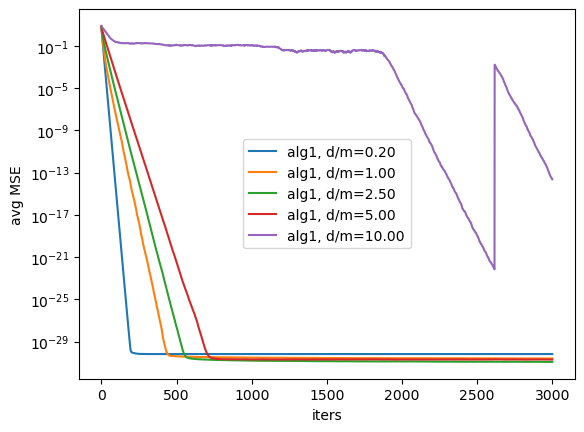

In [58]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
#     plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

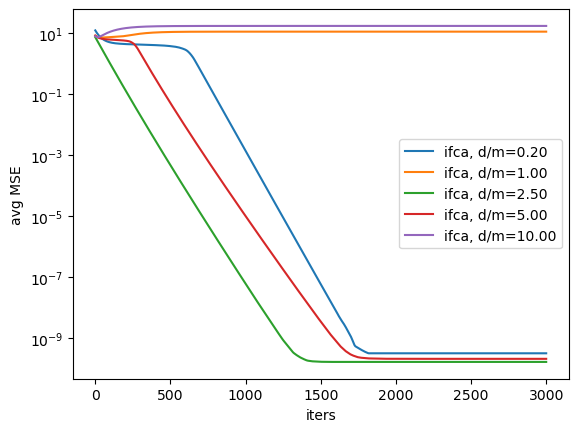

In [59]:
for item in range(len(d_over_m)):
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [179]:
import pandas as pd

In [180]:
x = [i for i in range(len(loss_dm_algo[0]))]
data = {'x': x}
for item in range(len(d_over_m)):
    data[d_over_m[item]] = loss_dm_algo[item]
    
df = pd.DataFrame.from_dict(data)

In [60]:
df.to_csv('clustered_FL_doverm.csv', sep=',')

In [181]:
x = [i for i in range(len(loss_dm_ifca[0]))]
data = {'x': x}
for item in range(len(d_over_m)):
    data[d_over_m[item]] = loss_dm_ifca[item]

df = pd.DataFrame.from_dict(data)    

In [182]:
df.to_csv('clustered_FL_ifca_doverm.csv', sep=',')

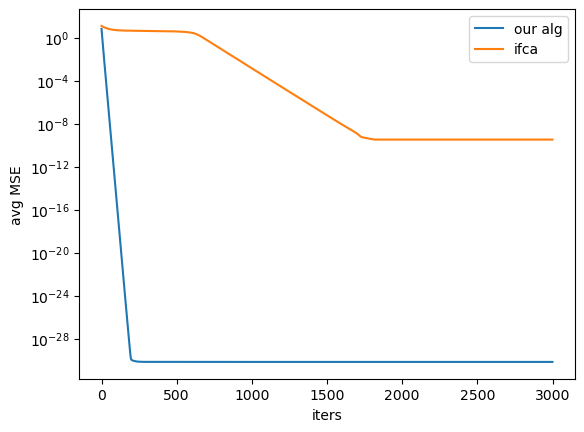

In [60]:
plt.plot([i for i in range(len(loss_dm_algo[0]))], loss_dm_algo[0], label='our alg')
plt.plot([i for i in range(len(loss_dm_ifca[0]))], loss_dm_ifca[0], label='ifca')
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

### Effect of noise in the algorithm performance

In [89]:
d_over_m = 0.2
noises = [0.0, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]
loss_dm_algo=[]
loss_dm_ifca=[]
K = 1500

for i in range(len(noises)):  
#     print(d_over_m[i])
    num_features = int(NUM_SAMPLES * d_over_m)
    X, y, w, clusters = get_data(num_features=num_features, noise=noises[i])
    true_w = []
    for c in range(NUM_CLUSTERS):    
        true_w.extend([w[c] for i in range(NUM_CLIENTS)])
    true_w = np.array(true_w)

    _, algo_loss_history = algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha)
    loss_dm_algo.append(algo_loss_history)    
    
    results, models, train_cluster = ifca_main(X, y, w, clusters, alpha, num_epochs=K)
    ifca_err = get_ifca_error(results, train_cluster)
    loss_dm_ifca.append(ifca_err)

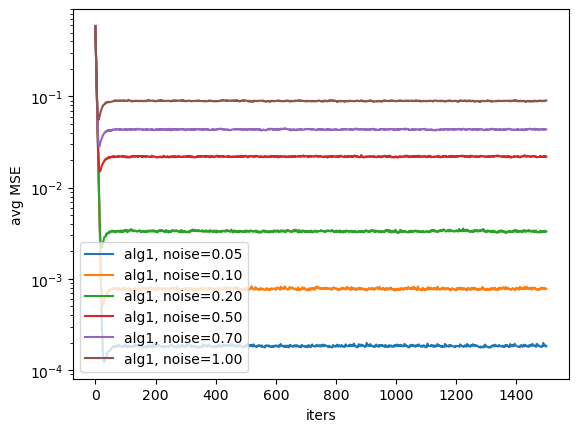

In [90]:
for item in range(len(noises)):
    if item == 0:
        continue
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, noise=%.2f' % noises[item])
#     plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

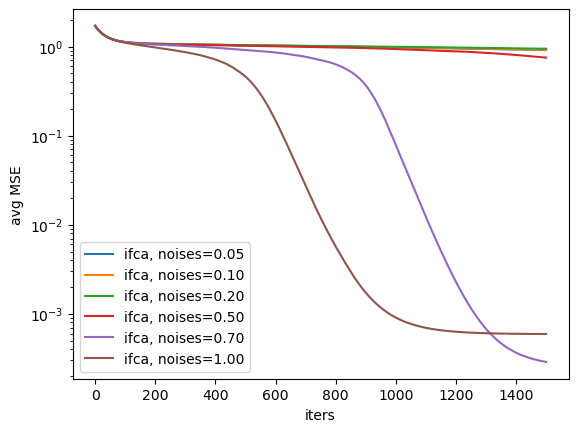

In [91]:
for item in range(len(noises)):
    if item == 0:
        continue
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, noise=%.2f' % noises[item])
    plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, noises=%.2f' % noises[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

### Effect of sample size in the algorithm performance

In [35]:
from collections import defaultdict
subset_sizes = [5, 10, 12, 15, 17, 20, 30]
d_over_m = 0.2
loss_dm_algo = defaultdict(list)

for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    print(subset_size)
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(NUM_CLIENTS)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

5
10
12
15
17
20
30


#### For N = 100

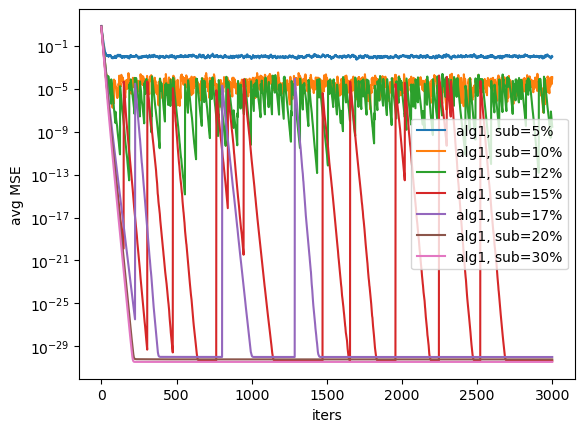

In [36]:
# for item in range(len(subset_sizes)):
for subset_size in subset_sizes:
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*NUM_CLIENTS)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='alg1, sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [42]:
subset_sizes = [5, 10, 20, 30, 40, 50, 60]
d_over_m = 0.2
loss_dm_algo = defaultdict(list)
NUM_CLIENTS = 100

for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    print(subset_size)
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features, num_clients=NUM_CLIENTS)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(NUM_CLIENTS)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

5
10
20
30
40
50
60


#### For N = 200

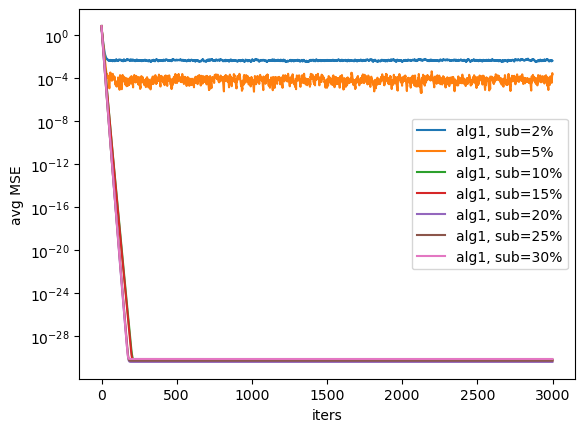

In [43]:
# for item in range(len(subset_sizes)):
for subset_size in subset_sizes:
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*NUM_CLIENTS)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='alg1, sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [44]:
subset_sizes = [10, 20, 30, 40, 50, 60]
d_over_m = 0.2
loss_dm_algo = defaultdict(list)
NUM_CLIENTS = 200


for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    print(subset_size)
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features, num_clients=NUM_CLIENTS)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(NUM_CLIENTS)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

10
20
30
40
50
60


#### For N = 400

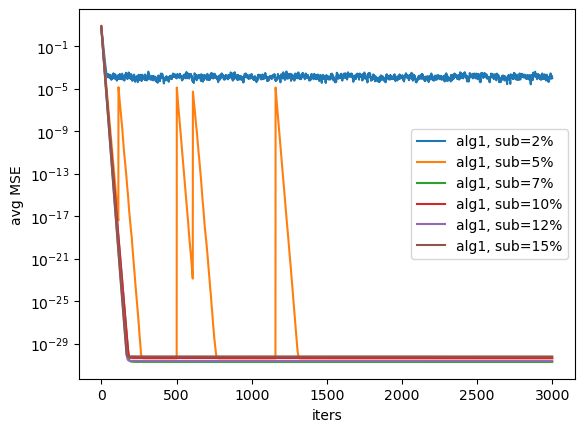

In [45]:
# for item in range(len(subset_sizes)):
for subset_size in subset_sizes:
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*NUM_CLIENTS)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='alg1, sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

## Non-parametric model

In [101]:
def get_data(num_features, num_clusters=NUM_CLUSTERS, num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0):
    w = np.random.uniform(-5,5,(num_clusters,num_features)) # here we shape all w for all clients
    clusters = []

    X = np.zeros((num_clusters,num_clients,num_training_samples,num_features)) 
    X_test = np.random.randn(num_training_samples,num_features)

    y = np.zeros ((num_clusters,num_clients,num_training_samples))
    localdatasets = np.zeros((num_clusters,num_clients,num_training_samples,(num_features+1)))
    clusterassgts = np.zeros((num_clusters,num_clients,num_training_samples))
    for iter_cluster in range(num_clusters): 
        for iter_node in range(0, num_clients):
            X[iter_cluster, iter_node,:,:] = np.random.randn(num_training_samples, num_features)
            r = X[iter_cluster, iter_node,:,:] @ w[iter_cluster, :].reshape(-1, 1) + np.random.normal(loc=0.0, scale=noise, size=(NUM_SAMPLES, 1))
            y[iter_cluster, iter_node,:] = r.squeeze()
            clusters.append(iter_cluster)
            for iter_sample in range(0,num_training_samples): 
                localdatasets[iter_cluster,iter_node,iter_sample,:] = np.hstack((X[iter_cluster, iter_node,iter_sample,:],y[iter_cluster, iter_node,iter_sample].reshape(-1,))).reshape(1,-1)
                clusterassgts[iter_cluster,iter_node,iter_sample] = iter_cluster


    X = X.reshape(-1, X.shape[2], X.shape[3])
    y = y.reshape(-1, y.shape[2])
    
    
    return X, y, w, clusters, X_test


In [196]:
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy


def MSE(y_true, y_pred):
    m = len(y)
    loss = (1 / m) * np.sum((y_pred - y_true) ** 2)
    return loss

def custom_loss(y_true, y_pred, lambda_value):
#     loss = np.mean(np.square(y_true - y_pred))  # Squared Euclidean distance
    loss = MSE(y_true, y_pred)
#     regularization_term = lambda_value * some_regularization_function(tree)  # Adjust as needed
    regularization_term = 0
    return loss + regularization_term

def non_param_algorithm(X, X_test, y, w, clusters, K, subset_size, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = [DecisionTreeRegressor(max_depth=1) for _ in range(N)]
    loss_history = []
    
    for i in range(N):
        w_hat[i].fit(X[i], y[i])
    
    mse = 0
    rewards = []
    for k in range(K):
        loss = []
#         print(k, mse, rewards)
        for i in range(N):
            selected_nodes = random.sample(nodes, subset_size+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:subset_size] 
            
            rewards = []
            _trees = []
            for node in selected_nodes:
#                 _tree = deepcopy(w_hat[i])
                updated_loss = custom_loss(y[node], w_hat[i].predict(X[node]), alpha)
                _X = np.concatenate([X[i], X[node]])
                _y = np.concatenate([w_hat[i].predict(X[i]), y[node]])
                sample_weight = np.concatenate([np.ones_like(y[i]), np.ones_like(y[node]) * updated_loss])
#                 _tree.fit(_X, _y, sample_weight=sample_weight)
                _tree = DecisionTreeRegressor(max_depth=1)
                _tree.fit(_X, _y)
                _trees.append(_tree)
                rewards.append(updated_loss)
#                 rewards.append(MSE(y[i], _tree.predict(X[i])))
                
#             best_tree = _trees[np.argmax(rewards)]
            best_tree = _trees[np.argmin(rewards)]

            w_hat[i] = deepcopy(best_tree)   
            
            mse = MSE(y[i], w_hat[i].predict(X[i]))
            loss.append(mse)
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

In [199]:
K = 10
d_over_m = [0.2, 1, 2.5, 5, 10]
loss_dm_algo=[]
for i in range(len(d_over_m)):  
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters, X_test = get_data(num_features=num_features, noise=0.5, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 5, alpha)
    loss_dm_algo.append(algo_loss_history)

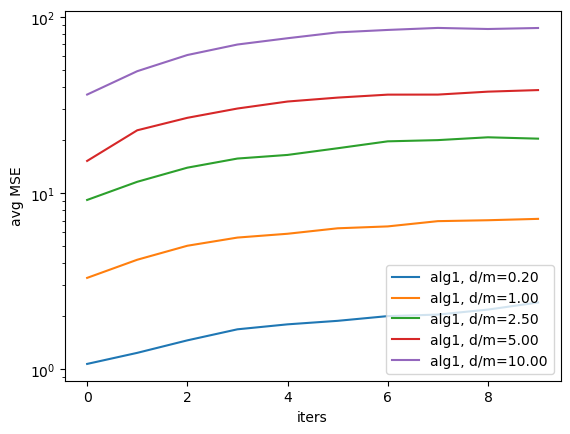

In [200]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()